In [89]:
# numpy  1.17.1
import numpy as np
# pandas  0.25.1
import pandas as pd
# scikit-learn  0.21.3
from scipy import interp
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import auc, confusion_matrix,  f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [90]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [91]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 280 columns


In [92]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64)

In [93]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

In [94]:
data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

In [95]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [96]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [97]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


# 切training data 和testing data

In [99]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [100]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# 建立Logistic Regression function

In [101]:
class LogisticRegression(object):

    def __init__(self, eta=0.0001, n_epoch=1000, random_state=1,thres=0.5):
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state
        self.thres = thres
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate loss"""
        sumcost = 0
        y =np.array(y)
        for i in range(len(y)):
            if y[i]==1:
                cost = np.log(output[i])
            else:
                 cost = np.log(1-output[i])
            sumcost+=cost
        return -sumcost
    
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        """Return class label after unit step"""
        pred = np.zeros(X.shape[0])
        pred[(1 / (1 + np.exp(-(np.dot(X, self.w_[1:]) + self.w_[0]))))>=self.thres ] = 1
        pred[(1 / (1 + np.exp(-(np.dot(X, self.w_[1:]) + self.w_[0]))))<self.thres ] = 0
        return pred

In [102]:
model = LogisticRegression()
model.fit(X_train_std,y_train)
y_pred = model.predict(X_test_std)

# 建立Confusion Matrix(Label 0 as positive)

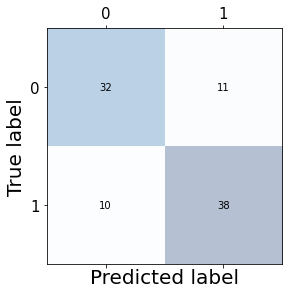

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('./output/fig-logistic-regression-confusion-2.png', dpi=300)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

# 得到F1 score=0.7529411764705882

In [107]:
f1_score(y_test, y_pred,pos_label=0)

0.7529411764705882